# 1 Introduction
Decision making is very important aspect of the field of finance. It is particularly important when in making investment decisions in financial markets. Numerous factors must be taken into consideration. This includes political, economic and social factors among many others. This makes predicting movements in financial markets particularly difficult. It is for this reason that technical analysis techniques, such as time series analysis, have become more important in the field. Investors, large and small, use technical analysis to analyse all available data for the purpose of reducing uncertainty and making more informed decisions. For example, an investor may want to invest in a company but wants to know if the price of the company’s stock will go up so he can make profit or avoid buying it if he expects the price to fall. This paper will demonstrate how time series analysis can be applied in analysing daily price movements of a stock of Chinese tech giant, Tencent Holdings Ltd (TCEHY). Historical data of Tencent’s stock price was collected, spanning the last 10 years (January 5th, 2010, October 9th, 2020), from the Yahoo Finance website. Contents of the dataset include daily high, low, open, close, and adjusted close prices of the TCEHY stock. The analysis of this paper will focus on the closing price (close).


In [84]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats


#Time Series Libraries and functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

In [85]:
#Load data
data = pd.read_csv('C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Tencent Stock Prices\\TCEHY.csv')

#make a copy
rdata = data[:]

In [86]:
rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 7 columns):
Date         2711 non-null object
Open         2711 non-null float64
High         2711 non-null float64
Low          2711 non-null float64
Close        2711 non-null float64
Adj Close    2711 non-null float64
Volume       2711 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 148.4+ KB


In [87]:
#Convert Date column to datetime format
rdata['Date'] = pd.to_datetime(rdata['Date'])
rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 7 columns):
Date         2711 non-null datetime64[ns]
Open         2711 non-null float64
High         2711 non-null float64
Low          2711 non-null float64
Close        2711 non-null float64
Adj Close    2711 non-null float64
Volume       2711 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 148.4 KB


# 2 Preliminary Analysis
The first step in any time series analysis is to observe the stationarity of the data. What this means is that the various statistical properties of the data, referring to the mean and variance, remain relatively stable over time. This is an import feature for data to have in a time series analysis as many forecasting models rely on stationarity and make the models more reliable.So before proceeding to fit a model and forecast future prices it is important we identify whether a time series process is stationary or non-stationary. The following 3 approaches were taken to observe the stationarity of the closing prices.
- Visualization of time series plots
- Review of summary statistics
- Run Augmented Dickey-Fuller test

#### Visualization of Time Series Plots

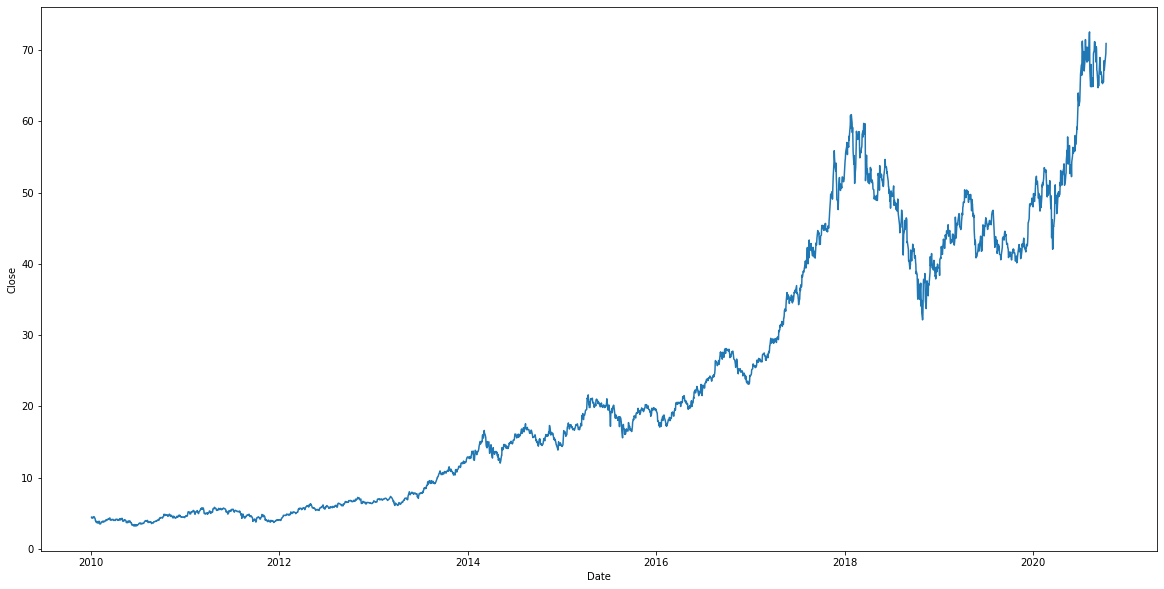

In [88]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = rdata, x = "Date", y = "Close")

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 1440x720 with 0 Axes>

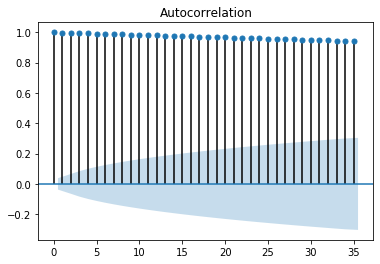

In [89]:
cprices = rdata['Close']
plt.figure(figsize=(20, 10))
plot_acf(cprices)
plt.show

#### Summary Statistics

<function matplotlib.pyplot.show(*args, **kw)>

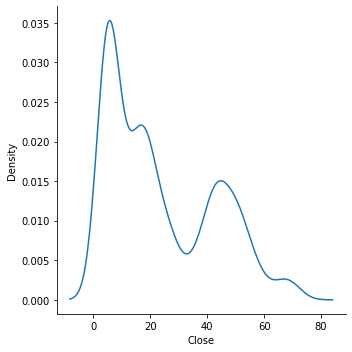

In [90]:
#2. Review Summary Statistics. Observe any changes in the mean and vaiance
sns.displot(cprices, kind = 'kde')
plt.show

In [91]:
split = round(len(cprices)/2)
cprice1 = cprices[0:split]
m1 = cprice1.mean()
v1 = stats.variance(cprice1)
cprice2 = cprices[split:]
m2 = cprice2.mean()
v2 = stats.variance(cprice2)

sum_dict = {'stat': ['Mean', 'Variance'], 'group1': [m1, v1], 'group2': [m2, v2]}
sumstats = pd.DataFrame(sum_dict)
sumstats

,stat,group1,group2
0,Mean,8.469965,38.719018
1,Variance,23.564218,204.301157


#### Augmented Dickey-Fuller Test for stationarity

In [92]:
print('Augmented Dickey-Fuller Test')
adftest = adfuller(cprices)
adfresult = pd.Series(adftest[0:4], index = ['Test Statistic', 'P-value', 'Lags', 'Observations'])
crits = pd.Series(adftest[4])
adfresult = pd.concat([adfresult, crits])
adfresult

Augmented Dickey-Fuller Test


Test Statistic       0.908837
P-value              0.993205
Lags                23.000000
Observations      2687.000000
1%                  -3.432786
5%                  -2.862616
10%                 -2.567343
dtype: float64

## 2.1 Applying log transformation and differencing
- Log transformation can help stabilize the variance
- Differencing can help stabilize the mean which can reduce or remove seasonality and trends
- Together these two transformations help in transforming a time series process from non-stationary to stationary

#### Visualization of Time Series Plots

In [93]:
lclose = np.log1p(cprices)
lcprices = lclose.diff()
rdata['lcprices'] = lcprices

<function matplotlib.pyplot.show(*args, **kw)>

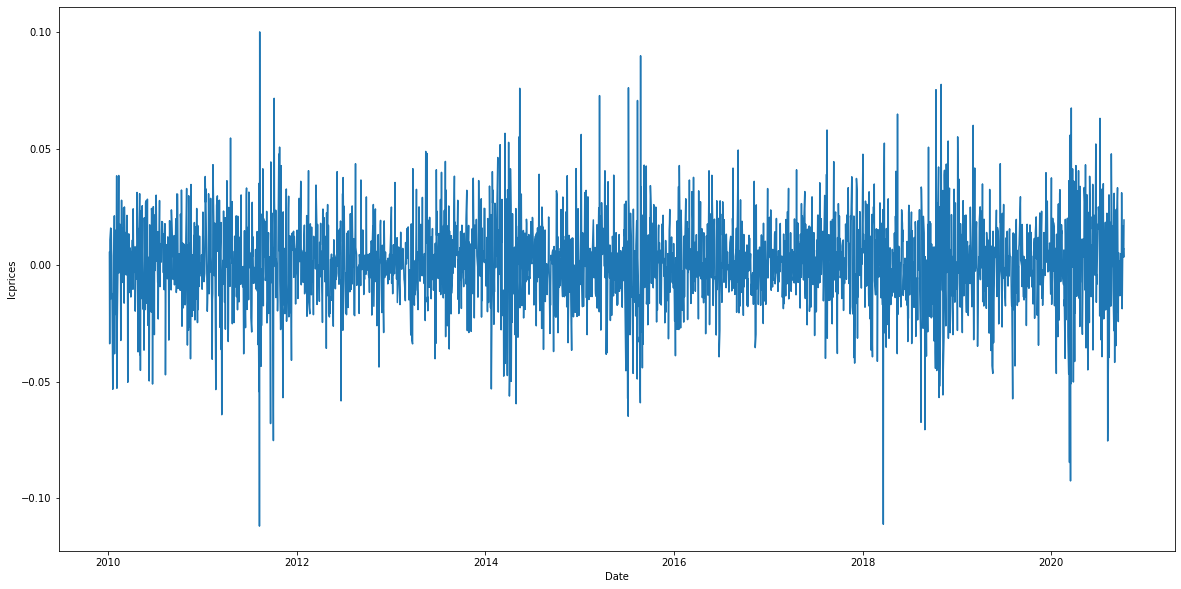

In [94]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = rdata, x = "Date", y = "lcprices")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 1440x720 with 0 Axes>

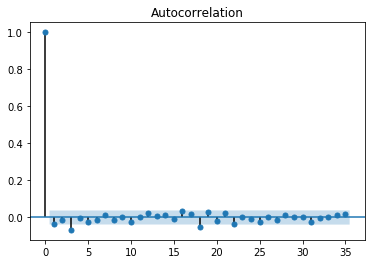

In [95]:
plt.figure(figsize=(20, 10))
plot_acf(lcprices[1:])
plt.show

#### Summary Statistics

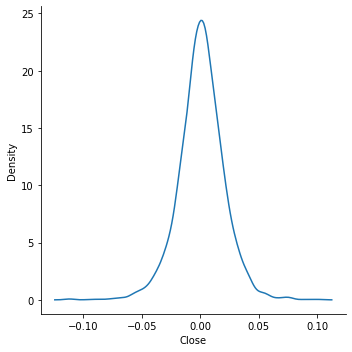

In [96]:
#2. Review Summary Statistics. Observe any changes in the mean and vaiance
sns.displot(lcprices, kind = 'kde')

In [97]:
split = round(len(lcprices)/2)
lcprice1 = lcprices[1:split]
m1 = lcprice1.mean()
v1 = stats.variance(lcprice1)
lcprice2 = lcprices[split:]
m2 = lcprice2.mean()
v2 = stats.variance(lcprice2)

sum_dict = {'stat': ['Mean', 'Variance'], 'group1': [m1, v1], 'group2': [m2, v2]}
sumstats = pd.DataFrame(sum_dict)
sumstats

,stat,group1,group2
0,Mean,0.001006,0.000898
1,Variance,0.000357,0.000406


#### Augmented Dickey-Fuller Test for stationarity

In [98]:
print('Augmented Dickey-Fuller Test')
adftest1 = adfuller(lcprices[1:])
adfresult1 = pd.Series(adftest1[0:4], index = ['Test Statistic', 'P-value', 'Lags', 'Observations'])
crits1 = pd.Series(adftest1[4])
adfresult1 = pd.concat([adfresult1, crits1])
adfresult1

Augmented Dickey-Fuller Test


Test Statistic     -32.787925
P-value              0.000000
Lags                 2.000000
Observations      2707.000000
1%                  -3.432768
5%                  -2.862608
10%                 -2.567339
dtype: float64

# 3 Model Fitting

#### Testing for white noise
- Before fitting a model for use in forecasting we will test to see if our time series process can be used for forecasting. This will be done by testing for white noise.
- White noise processes have have constant variances and means as well as autocorrelations equal to zero
- Forecasting is not possible with a white noise process hence why we test for it
- We use the ljung-box test to check for white noise
- This null hypothesis for the ljung-box test states that autocorrelations are equal to zero. If null hypothesis holds then the time series process is a white noise process

In [99]:
acorr_ljungbox(lcprices[1:], lags = [10])

(array([21.21876577]), array([0.0196187]))

- Given the values above we can reject the null hypothesis

#### Identify and Fitting an Appropriate Model

<function matplotlib.pyplot.show(*args, **kw)>

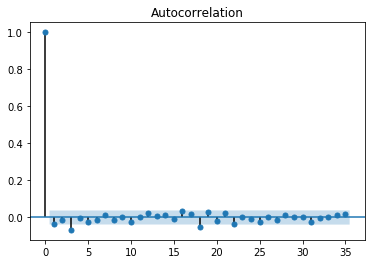

In [100]:
plot_acf(lcprices[1:])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

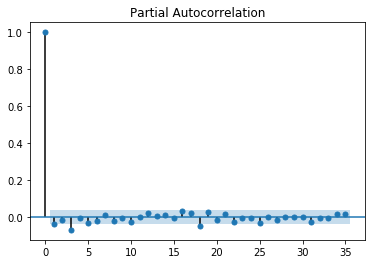

In [101]:
plot_pacf(lcprices[1:])
plt.show

- Based on the Pacf and Acf graphs its clear to see that the model may be MA(1) evident by The very high lag followed by lags closer to zero
- We can try a couple models ARMA(0,1) and ARMA(1,1)

In [102]:
mod = ARIMA(lcprices[1:], order=(0, 0, 1))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2710
Model:                     ARMA(0, 1)   Log Likelihood                6823.392
Method:                       css-mle   S.D. of innovations              0.020
Date:                Wed, 21 Oct 2020   AIC                         -13640.785
Time:                        21:29:54   BIC                         -13623.071
Sample:                             0   HQIC                        -13634.380
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0010      0.000      2.636      0.008       0.000       0.002
ma.L1.Close    -0.0369      0.020     -1.884      0.060      -0.075       0.001
                                    Roots       

In [103]:
mod2 = ARIMA(lcprices[1:], order=(1, 0, 1))
res2 = mod2.fit()
print(res2.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2710
Model:                     ARMA(1, 1)   Log Likelihood                6827.763
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 21 Oct 2020   AIC                         -13647.526
Time:                        21:29:55   BIC                         -13623.907
Sample:                             0   HQIC                        -13638.986
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0010      0.000      3.085      0.002       0.000       0.002
ar.L1.Close     0.7432      0.092      8.119      0.000       0.564       0.923
ma.L1.Close    -0.7883      0.084     -9.401    